<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#General-imports" data-toc-modified-id="General-imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>General imports</a></span></li><li><span><a href="#The-class-for-the-network" data-toc-modified-id="The-class-for-the-network-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>The class for the network</a></span></li><li><span><a href="#Some-other-functions" data-toc-modified-id="Some-other-functions-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Some other functions</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Create-overlapped-representations" data-toc-modified-id="Create-overlapped-representations-1.3.0.1"><span class="toc-item-num">1.3.0.1&nbsp;&nbsp;</span>Create overlapped representations</a></span></li></ul></li></ul></li><li><span><a href="#Some-general-parameters" data-toc-modified-id="Some-general-parameters-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Some general parameters</a></span></li></ul></li><li><span><a href="#z-variables-as-transfers" data-toc-modified-id="z-variables-as-transfers-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>z-variables as transfers</a></span><ul class="toc-item"><li><span><a href="#An-example-to-see-it-works" data-toc-modified-id="An-example-to-see-it-works-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>An example to see it works</a></span></li><li><span><a href="#Disambiguation" data-toc-modified-id="Disambiguation-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Disambiguation</a></span></li></ul></li></ul></div>

# Preamble

## General imports

In [1]:
import  pprint
import  subprocess 
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0)

np.set_printoptions(suppress=True, precision=5)

sns.set(font_scale=2.5)

from network import Protocol
from patterns_representation import PatternsRepresentation
from analysis_functions import calculate_persistence_time, calculate_recall_quantities
from plotting_functions import plot_weight_matrix, plot_network_activity_angle, plot_persistent_matrix

## The class for the network

In [2]:
from connectivity_functions import softmax, get_w_pre_post, get_beta, strict_max
from connectivity_functions import create_weight_matrix
from patterns_representation import create_canonical_activity_representation, build_network_representation


In [3]:
class Network:
    def __init__(self, hypercolumns, minicolumns, G=1.0, tau_s=0.010, tau_z_pre=0.050, tau_z_post=0.005,
                 tau_a=0.250, g_a=1.0, g_I=10.0, sigma_out=0.0, epsilon=1e-60, g_beta=1.0, prng=np.random,
                 strict_maximum=True, perfect=False, normalized_currents=True):

        # Random number generator
        self.prng = prng
        self.sigma_out = sigma_out   # The variance that the system would have on the steady state if were to have it
        self.sigma_in = sigma_out * np.sqrt(2 / tau_s)    # Ornstein-Uhlenbeck process
        self.epsilon = epsilon

        # Network parameters
        self.hypercolumns = hypercolumns
        self.minicolumns = minicolumns

        self.n_units = self.hypercolumns * self.minicolumns

        # Network variables
        self.strict_maximum = strict_maximum
        self.perfect = perfect
        self.normalized_current = normalized_currents
        if self.normalized_current:
            self.normalized_constant = self.hypercolumns
        else:
            self.normalized_constant = 1.0

        #  Dynamic Parameters
        self.tau_s = tau_s
        self.tau_a = tau_a
        self.r = self.tau_s / self.tau_a
        self.g_beta = g_beta
        self.g_a = g_a
        self.g_I = g_I
        self.tau_z_pre = tau_z_pre
        self.tau_z_post = tau_z_post
        self.G = G

        # State variables
        self.o = np.full(shape=self.n_units, fill_value=0.0)
        self.s = np.full(shape=self.n_units, fill_value=0.0)
        self.a = np.full(shape=self.n_units, fill_value=0.0)
        self.I = np.full(shape=self.n_units, fill_value=0.0)

        # Current values
        self.i = np.full(shape=self.n_units, fill_value=0.0)
        self.z_pre = np.full(shape=self.n_units, fill_value=0.0)
        self.z_post = np.full(shape=self.n_units, fill_value=0.0)
        self.z_co = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)

        # Keeping track of the probability / connectivity
        self.t_p = 0.0
        self.p_pre = np.full(shape=self.n_units, fill_value=0.0)
        self.p_post = np.full(shape=self.n_units, fill_value=0.0)
        self.P = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)
        self.w = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)
        self.beta = np.full(shape=self.n_units, fill_value=0.0)

    def parameters(self):
        """
        Get the parameters of the model

        :return: a dictionary with the parameters
        """
        parameters = {'tau_s': self.tau_s, 'tau_z_post': self.tau_z_post, 'tau_z_pre': self.tau_z_pre,
                      'tau_a': self.tau_a, 'g_a': self.g_a, 'g_I':self.g_I,  'epsilon': self.epsilon,
                      'G': self.G, 'sigma_out':self.sigma_out, 'sigma_in': self.sigma_in,
                      'perfect': self.perfect, 'strict_maximum': self.strict_maximum}

        return parameters

    def reset_values(self, keep_connectivity=True):
        # State variables
        self.o = np.full(shape=self.n_units, fill_value=0.0)
        self.s = np.full(shape=self.n_units, fill_value=0.0)

        self.a = np.full(shape=self.n_units, fill_value=0.0)
        self.I = np.full(shape=self.n_units, fill_value=0.0)

        # Current values
        self.i = np.full(shape=self.n_units, fill_value=0.0)
        self.z_pre = np.full(shape=self.n_units, fill_value=0.0)
        self.z_post = np.full(shape=self.n_units, fill_value=0.0)
        self.z_co = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)

        if not keep_connectivity:
            self.beta = np.full(shape=self.n_units, fill_value=0.0)
            self.w = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)

            self.p_pre = np.full(shape=self.n_units, fill_vale=0.0)
            self.p_post = np.full(shape=self.n_units, fill_value=0.0)
            self.P = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)

    def update_continuous(self, dt=1.0, sigma=None):
        # Get the noise
        if sigma is None:
            noise = self.sigma_in * np.sqrt(dt) * self.prng.normal(0, 1.0, self.n_units)
        else:
            noise = sigma

        # Calculate currents
        self.i = self.w @ self.z_pre / self.normalized_constant
        if self.perfect:
            self.s = self.i + self.g_beta * self.beta - self.g_a * self.a + self.g_I * self.I + noise
        else:
            self.s += (dt / self.tau_s) * (self.i  # Current
                                           + self.g_beta * self.beta  # Bias
                                           + self.g_I * self.I  # Input current
                                           - self.g_a * self.a  # Adaptation
                                           - self.s)  # s follow all of the s above
            self.s += noise
        # Non-linearity
        if self.strict_maximum:
            self.o = strict_max(self.s, minicolumns=self.minicolumns)
        else:
            self.o = softmax(self.s, G=self.G, minicolumns=self.minicolumns)

        # Update the z-traces
        self.z_pre += (dt / self.tau_z_pre) * (self.o - self.z_pre)
        self.z_post += (dt / self.tau_z_post) * (self.o - self.z_post)
        self.z_co = np.outer(self.z_post, self.z_pre)
        
        # Update the adaptation
        self.a += (dt / self.tau_a) * (self.o - self.a)

    def update_probabilities(self, dt):
        if self.t_p > 0.0:
            time_factor = dt / self.t_p
            self.p_pre += time_factor * (self.z_pre - self.p_pre)
            self.p_post += time_factor * (self.z_post - self.p_post)
            self.P += time_factor * (self.z_co - self.P)
        self.t_p += dt

    def update_weights(self):
        # Update the connectivity
        self.beta = get_beta(self.p_post, self.epsilon)
        self.w = get_w_pre_post(self.P, self.p_pre, self.p_post, self.epsilon, diagonal_zero=False)


class NetworkManager:
    """
    This class will run the Network. Everything from running, saving and calculating quantities should be
    methods in this class.  In short this will do the running of the network, the learning protocols, etcera.

    Note that data analysis should be conducted into another class preferably.
    """

    def __init__(self, nn=None, dt=0.001, values_to_save=[]):
        """
        :param nn: A network instance
        :param time: A numpy array with the time to run
        :param values_to_save: a list with the values as strings of the state variables that should be saved
        """

        self.nn = nn

        # Timing variables
        self.dt = dt
        self.T_training_total = 0.0
        self.T_recall_total = 0.0
        self.n_time_total = 0
        self.time = None

        # Initialize saving dictionary
        self.saving_dictionary = self.get_saving_dictionary(values_to_save)

        # Initialize the history dictionary for saving values
        self.history = None
        self.empty_history()

        # Get reference representations
        self.canonical_activity_representation = create_canonical_activity_representation(self.nn.minicolumns,
                                                                                          self.nn.hypercolumns)
        self.canonical_network_representation = build_network_representation(self.canonical_activity_representation,
                                                                             self.nn.minicolumns)
        # Dictionary to see what has been taught to the network
        # self.n_patterns = 0
        self.patterns_dic = None
        self.network_representation = np.array([]).reshape(0, self.nn.n_units)

        # Training matrices
        self.B = None
        self.T = None
        self.w_diff = np.zeros_like(self.nn.w)
        self.beta_diff = np.zeros_like(self.nn.w)

    def get_saving_dictionary(self, values_to_save):
        """
        This resets the saving dictionary and only activates the values in values_to_save
        """

        # Reinitialize the dictionary
        saving_dictionary = {'o': False, 's': False, 'a': False,
                             'z_pre': False, 'z_post': False, 'z_co': False,
                             'p_pre': False, 'p_post': False, 'P': False,
                             'i': False, 'w': False, 'beta': False}

        # Activate the values passed to the function
        for state_variable in values_to_save:
            saving_dictionary[state_variable] = True

        return saving_dictionary

    def empty_history(self):
        """
        A function to empty the history
        """
        empty_array = np.array([]).reshape(0, self.nn.n_units)
        empty_array_square = np.array([]).reshape(0, self.nn.n_units, self.nn.n_units)

        self.history = {'o': empty_array, 's': empty_array, 'a': empty_array,
                        'z_pre': empty_array, 'z_post': empty_array, 'z_co': empty_array_square,
                        'p_pre': empty_array, 'p_post': empty_array, 'P': empty_array_square,
                        'i': empty_array, 'w': empty_array_square, 'beta': empty_array}

    def append_history(self, history, saving_dictionary):
        """
        This function is used at every step of a process that is going to be saved. The items given by
        saving dictinoary will be appended to the elements of the history dictionary.

        :param history: is the dictionary with the saved values
        :param saving_dictionary:  a saving dictionary with keys as the parameters that should be saved
        and items as boolean indicating whether that parameters should be saved or not
        """

        # Dynamical variables
        if saving_dictionary['o']:
            history['o'].append(np.copy(self.nn.o))
        if saving_dictionary['s']:
            history['s'].append(np.copy(self.nn.s))
        if saving_dictionary['a']:
            history['a'].append(np.copy(self.nn.a))
        if saving_dictionary['i']:
            history['i'].append(np.copy(self.nn.i))
        if saving_dictionary['z_pre']:
            history['z_pre'].append(np.copy(self.nn.z_pre))
        if saving_dictionary['z_post']:
            history['z_post'].append(np.copy(self.nn.z_post))
        if saving_dictionary['z_co']:
            history['z_co'].append(np.copy(self.nn.z_co))
        if saving_dictionary['p_pre']:
            history['p_pre'].append(np.copy(self.nn.p_pre))
        if saving_dictionary['p_post']:
            history['p_post'].append(np.copy(self.nn.p_post))
        if saving_dictionary['P']:
            history['P'].append(np.copy(self.nn.P))
        if saving_dictionary['w']:
            history['w'].append(np.copy(self.nn.w))
        if saving_dictionary['beta']:
            history['beta'].append(np.copy(self.nn.beta))

    def update_patterns(self, nr):
        self.network_representation = np.concatenate((self.network_representation, nr))
        aux, indexes = np.unique(self.network_representation, axis=0, return_index=True)
        patterns_dic = {index: pattern for (index, pattern) in zip(indexes, aux)}
        self.patterns_dic = patterns_dic

    def run_network(self, time=None, I=None, train_network=False, plasticity_on=False):
        # Change the time if given

        if time is None or len(time) == 0:
            raise ValueError('Time should be given and be an array')

        # Load the clamping if available
        if I is None:
            self.nn.I = np.zeros_like(self.nn.o)
        elif isinstance(I, (float, int)):
            self.nn.I = self.patterns_dic[I]
        else:
            self.nn.I = I  # The pattern is the input
        # Create a vector of noise
        noise = self.nn.prng.normal(loc=0, scale=1, size=(time.size, self.nn.n_units))
        noise *= self.nn.sigma_in * np.sqrt(self.dt)

        # Initialize run history
        step_history = {}

        # Create a list for the values that are in the saving dictionary
        for quantity, boolean in self.saving_dictionary.items():
            if boolean:
                step_history[quantity] = []

        # Run the simulation and save the values
        for index_t, t in enumerate(time):
            # Append the history first
            self.append_history(step_history, self.saving_dictionary)
            # Update the system dynamic variables
            self.nn.update_continuous(dt=self.dt, sigma=noise[index_t, :])
            # Update the learning variables
            if train_network:
                self.nn.update_z_values(dt=self.dt)
                self.nn.update_probabilities(dt=self.dt)
            # Update the weights
            if plasticity_on:
                self.nn.update_weights()

        # Concatenate with the past history and redefine dictionary
        for quantity, boolean in self.saving_dictionary.items():
            if boolean:
                self.history[quantity] = np.concatenate((self.history[quantity], step_history[quantity]))

        return self.history

    def run_network_protocol(self, protocol, plasticity_on=False, verbose=True,
                             values_to_save_epoch=None, reset=True, empty_history=True):

        if empty_history:
            self.empty_history()
            self.T_training_total = 0
        if reset:
            self.nn.reset_values(keep_connectivity=True)

        # Updated the stored patterns
        self.update_patterns(protocol.network_representation)

        # Unpack the protocol
        times = protocol.times_sequence
        patterns_sequence = protocol.patterns_sequence
        learning_constants = protocol.learning_constants_sequence  # The values of Kappa

        # Initialize dictionary for storage
        epoch_history = {}
        if values_to_save_epoch:
            saving_dictionary_epoch = self.get_saving_dictionary(values_to_save_epoch)
            # Create a list for the values that are in the saving dictionary
            for quantity, boolean in saving_dictionary_epoch.items():
                if boolean:
                    epoch_history[quantity] = []

        # Run the protocol
        epochs = 0
        start_time = 0.0
        n_aux = 0
        for time, pattern, k in zip(times, patterns_sequence, learning_constants):
            # End of the epoch
            if pattern == epoch_end_string:
                # Store the values at the end of the epoch
                if values_to_save_epoch:
                    self.append_history(epoch_history, saving_dictionary_epoch)

                if verbose:
                    print('epochs', epochs)
                    epochs += 1

            # Running step
            else:
                running_time = np.arange(start_time, start_time + time, self.dt)
                self.run_network(time=running_time, I=pattern, train_network=True, plasticity_on=plasticity_on)
                start_time += time
                n_aux += running_time.size

        # Get timings quantities
        self.T_training_total += start_time
        self.n_time_total += n_aux
        self.time = np.linspace(0, self.T_training_total, num=self.n_time_total)

        # Update weights
        if not plasticity_on:
            self.nn.update_weights()

        # Return the history if available
        if values_to_save_epoch:
            return epoch_history

    def run_network_protocol_offline(self, protocol):
        # Build time input
        timed_input = TimedInput(protocol, self.dt)
        timed_input.build_timed_input()
        timed_input.build_filtered_input_pre(tau_z=self.nn.tau_z_pre)
        timed_input.build_filtered_input_post(tau_z=self.nn.tau_z_post)
        # Calculate probabilities
        self.nn.p_pre, self.nn.p_post, self.nn.P = timed_input.calculate_probabilities_from_time_signal()
        # Store the connectivity values
        self.nn.beta = get_beta(self.nn.p_post, self.nn.epsilon)
        self.nn.w = get_w_pre_post(self.nn.P, self.nn.p_pre, self.nn.p_post, self.nn.epsilon, diagonal_zero=False)

        # Update the patterns
        self.update_patterns(protocol.network_representation)

        # Get timings quantities
        t_total, n_time_total, time = protocol.calculate_time_quantities(self.dt)
        self.T_training_total += t_total
        self.n_time_total += n_time_total
        self.time = np.linspace(0, self.T_training_total, num=self.n_time_total)

        return timed_input

    def run_artificial_protocol(self, ws=1.0, wn=0.25, wb=-3.0, alpha=0.5, alpha_back=None, cycle=False):
        """
        This creates an artificial matrix
        :return: w, the weight matrix that was created
        """
        minicolumns = self.nn.minicolumns
        extension = self.nn.minicolumns
        sequence = self.canonical_activity_representation
        if cycle:
            sequence = np.append(sequence, sequence[0]).reshape(self.nn.minicolumns + 1, self.nn.hypercolumns)

        w = create_weight_matrix(minicolumns, sequence, ws, wn, wb, alpha,
                                 alpha_back, extension, w=None)
        self.nn.w = w

        p = np.ones(self.nn.n_units) * (1.0/ len(sequence))
        self.nn.beta = get_beta(p, self.nn.epsilon)

        # Updated the patterns in the network
        nr = self.canonical_network_representation
        self.update_patterns(nr)

        return w

    def run_network_recall(self, T_recall=10.0, T_cue=0.0, I_cue=None, reset=True,
                           empty_history=True, plasticity_on=False, stable_start=True):
        """
        Run network free recall
        :param T_recall: The total time of recalling
        :param T_cue: the time that the cue is run
        :param I_cue: The current to give as the cue
        :param reset: Whether the state variables values should be returned
        :param empty_history: whether the history should be cleaned
        """
        if T_recall < 0.0:
            raise ValueError('T_recall = ' + str(T_recall) + ' has to be positive')
        time_recalling = np.arange(0, T_recall, self.dt)
        time_cue = np.arange(0, T_cue, self.dt)

        if plasticity_on:
            train_network = True
        else:
            train_network = False

        if empty_history:
            self.empty_history()
        if reset:
            # Never destroy connectivity while recalling
            self.nn.reset_values(keep_connectivity=True)
            # Recall times
            self.T_recall_total = 0
            self.n_time_total = 0

        # Set initial conditions of the current to the clamping if available
        if stable_start:
            if I_cue is None:
                pass
            elif isinstance(I_cue, (float, int)):
                self.nn.s = self.nn.g_I * self.patterns_dic[I_cue].astype('float')
                self.nn.o = strict_max(self.nn.s, minicolumns=self.nn.minicolumns)
                self.nn.i = self.nn.w @ self.nn.o / self.nn.normalized_constant
                self.nn.s += self.nn.i + self.nn.beta - self.nn.g_a * self.nn.a
            else:
                self.nn.s = self.nn.g_I * I_cue  # The pattern is the input
                self.nn.o = strict_max(self.nn.s, minicolumns=self.nn.minicolumns)
                self.nn.i = self.nn.w @ self.nn.o / self.nn.normalized_constant
                self.nn.s += self.nn.i + self.nn.beta - self.nn.g_a * self.nn.a

        # Run the cue
        if T_cue > 0.001:
            self.run_network(time=time_cue, I=I_cue, train_network=train_network, plasticity_on=plasticity_on)

        # Run the recall
        self.run_network(time=time_recalling, train_network=train_network, plasticity_on=plasticity_on)

        # Calculate total time
        self.T_recall_total += T_recall + T_cue
        self.n_time_total += self.history['o'].shape[0]
        self.time = np.linspace(0, self.T_recall_total, num=self.n_time_total)

    def set_persistent_time_with_adaptation_gain(self, T_persistence, from_state=2, to_state=3):
        """
        This formula adjusts the adpatation gain g_a so the network with the current weights lasts for T_persistence
        when passing from `from_state' to `to_state'
        :param T_persistence: The persistent time necessary
        :param from_state: the state tat will last T_persistent seconds activated
        :param to_state: the state that it will go to
        :return: g_a the new adaptation
        """

        delta_w = self.nn.w[from_state, from_state] - self.nn.w[to_state, from_state]
        delta_beta = self.nn.beta[from_state] - self.nn.beta[to_state]
        aux = 1 - np.exp(-T_persistence / self.nn.tau_a) / (1 - self.nn.r)
        g_a = (delta_w + delta_beta) / aux

        self.nn.g_a = g_a

        return g_a

    def calculate_persistence_time_matrix(self):

        self.w_diff = self.nn.w.diagonal() - self.nn.w
        self.beta_diff = (self.nn.beta[:, np.newaxis] - self.nn.beta[np.newaxis, :]).T

        self.B = (self.w_diff + self.beta_diff) / self.nn.g_a
        self.T = self.nn.tau_a * np.log(1 / (1 - self.B))
        if not self.nn.perfect:
            self.T += self.nn.tau_a * np.log(1 / (1 - self.nn.r))

        self.T[self.T < 0] = 0.0
        return self.T
    
class TimedInput:
    def __init__(self, protocol, dt):

        self.protocol = protocol
        self.n_patterns = protocol.n_patterns
        self.n_units = protocol.network_representation.shape[1]
        self.dt = dt

        self.T_protocol_total, self.n_time_total, self.time = protocol.calculate_time_quantities(self.dt)

        self.network_representation = protocol.network_representation
        self.O = np.zeros((self.n_units, self.n_time_total))
        self.z_pre = np.zeros_like(self.O)
        self.z_post = np.zeros_like(self.O)
        self.tau_z_pre = None
        self.tau_z_post = None

    def build_timed_input(self):
        end = 0
        for epoch in range(self.protocol.epochs):
            for pattern, (training_time, inter_pulse_interval) in \
                    enumerate(zip(self.protocol.training_times, self.protocol.inter_pulse_intervals)):

                pattern_length = int(training_time / self.dt)
                inter_pulse_interval_length = int(inter_pulse_interval / self.dt)
                start = end
                end = start + pattern_length
                # Add the input
                indexes = np.where(self.network_representation[pattern])[0]
                self.O[indexes, start:end] = 1
                end += inter_pulse_interval_length

            inter_sequence_interval_length = int(self.protocol.inter_sequence_interval / self.dt)
            end += inter_sequence_interval_length

        return self.O

    def build_filtered_input_pre(self, tau_z):
        self.tau_z_pre = tau_z
        for index, o in enumerate(self.O.T):
            if index == 0:
                self.z_pre[:, index] = (self.dt / tau_z) * (o - 0)
            else:
                self.z_pre[:, index] = self.z_pre[:, index - 1] + (self.dt / tau_z) * (o - self.z_pre[:, index - 1])

        return self.z_pre

    def build_filtered_input_post(self, tau_z):
        self.tau_z_post = tau_z
        for index, o in enumerate(self.O.T):
            if index == 0:
                self.z_post[:, index] = (self.dt / tau_z) * (o - 0)
            else:
                self.z_post[:, index] = self.z_post[:, index - 1] + (self.dt / tau_z) * (o - self.z_post[:, index - 1])

        return self.z_post

    def calculate_probabilities_from_time_signal(self, filtered=True):
        if filtered:
            y_pre = self.z_pre
            y_post = self.z_post
        else:
            y_pre = self.O
            y_post = self.O

        n_units = self.n_units
        n_time_total = self.n_time_total

        p_pre = sp.integrate.simps(y=y_pre, x=self.time, axis=1) / self.T_protocol_total
        p_post = sp.integrate.simps(y=y_post, x=self.time, axis=1) / self.T_protocol_total

        outer_product = np.zeros((n_units, n_units, n_time_total))
        for index, (s_pre, s_post) in enumerate(zip(y_pre.T, y_post.T)):
            outer_product[:, :, index] = s_post[:, np.newaxis] @ s_pre[np.newaxis, :]

        P = sp.integrate.simps(y=outer_product, x=self.time, axis=2) / self.T_protocol_total

        return p_pre, p_post, P

## Some other functions

#### Create overlapped representations

In [4]:
from copy import deepcopy

def create_overalaped_representation(manager, representation_overlap, sequence_overlap):
    x = deepcopy(manager.canonical_activity_representation)

    to_modify = int(representation_overlap * len(x[0]))
    sequence_size = int(0.5 * len(x))
    sequence_overlap_size = int(sequence_overlap * sequence_size)
    start_point = int(0.5 * sequence_size + sequence_size - np.floor(sequence_overlap_size/ 2.0))
    end_point = start_point + sequence_overlap_size

    for sequence_index in range(start_point, end_point):
        pattern = x[sequence_index]
        pattern[:to_modify] = manager.canonical_activity_representation[sequence_index - sequence_size][:to_modify]

    return x

## Some general parameters

In [5]:
epsilon = 1e-7
vmin = -6.0
remove = 0.010

strict_maximum = True

dt = 0.001
tau_s = 0.010
tau_a = 0.250
g_I = 3.0
g_a = 2.0
G = 50.0

sns.set(font_scale=3.5)
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['figure.figsize'] = (12, 8)
lw = 10
ms = 22
alpha_graph = 0.3
colors = sns.color_palette()

# z-variables as transfers

## An example to see it works

In [6]:
%%time

sigma_out = 0.0
tau_z_pre = 0.100
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 10
n_patterns = minicolumns

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.000
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 0.0
epochs = 1
T_persistence = 0.100

# Manager properties
values_to_save = ['o', 'i', 'z_pre', 's']

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)

# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)


sigma_number = 15
samples = 25
sigma_max = 2

CPU times: user 20 ms, sys: 8 ms, total: 28 ms
Wall time: 27.2 ms


pattern sequence [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
times [0.073, 0.272, 0.321, 0.323, 0.323, 0.323, 0.323, 0.323, 0.387, 0.36]
T_calculated 0.32437499999999997


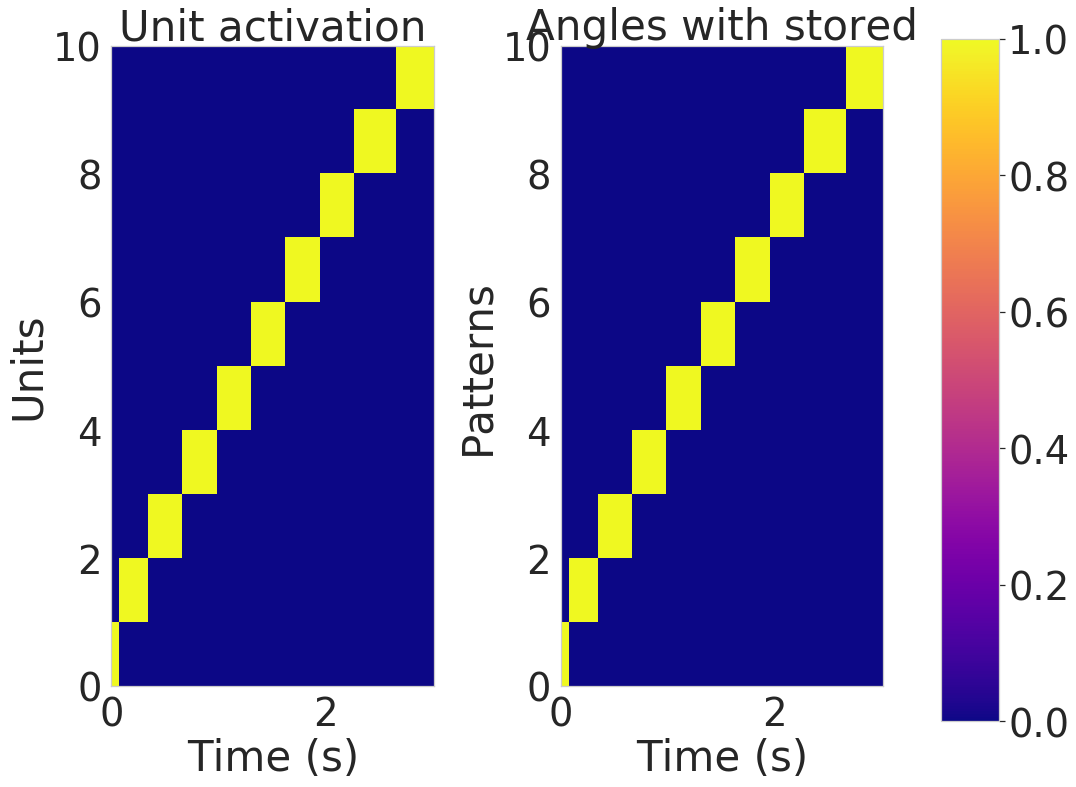

In [7]:
manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence, from_state=1, to_state=2)

T_cue = 1.0 * manager.nn.tau_s
T_recall = 3 * T_persistence * n_patterns + T_cue

# Success
nr = representation.network_representation
aux = calculate_recall_quantities(manager, nr, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
success, pattern_sequence, persistent_times, timings = aux

print('pattern sequence', pattern_sequence)
print('times', persistent_times)
print('T_calculated', np.mean(persistent_times[1:-1]))
plot_network_activity_angle(manager, time_y=False);

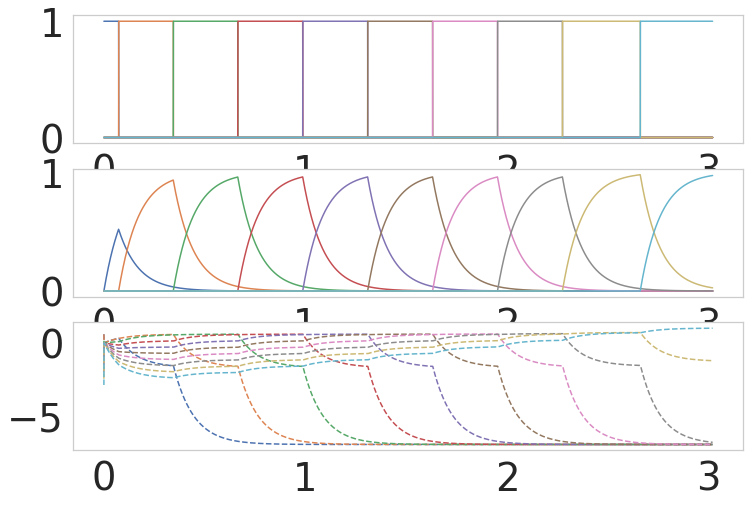

In [8]:
I = manager.history['i']
O = manager.history['o']
Z_pre = manager.history['z_pre']
S = manager.history['s']

fig = plt.figure()
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

for o in O.T:
    ax1.plot(manager.time, o)
    
for current in I.T:
    ax3.plot(manager.time, current, ls='--')
    
for z in Z_pre.T:
    ax2.plot(manager.time, z)

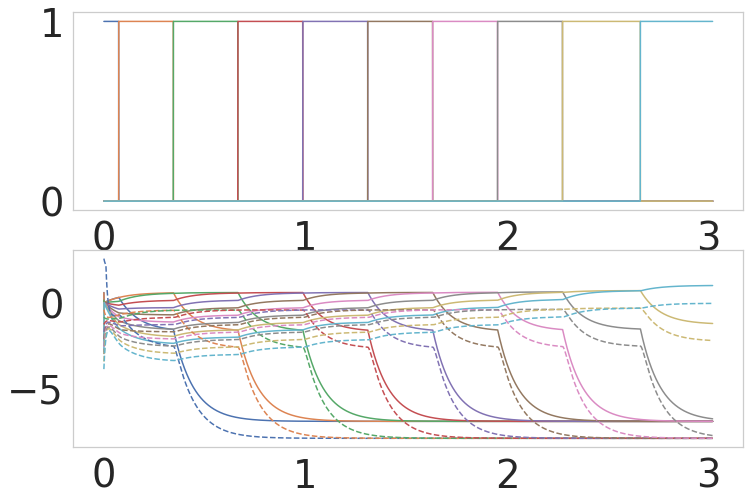

In [9]:
I = manager.history['i']
O = manager.history['o']
Z_pre = manager.history['z_pre']

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for o in O.T:
    ax1.plot(manager.time, o)
    
for index, current in enumerate(I.T):
    ax2.plot(manager.time, current, color=colors[index])
for index, s in enumerate(S.T):
    ax2.plot(manager.time, s, ls='--', color=colors[index])

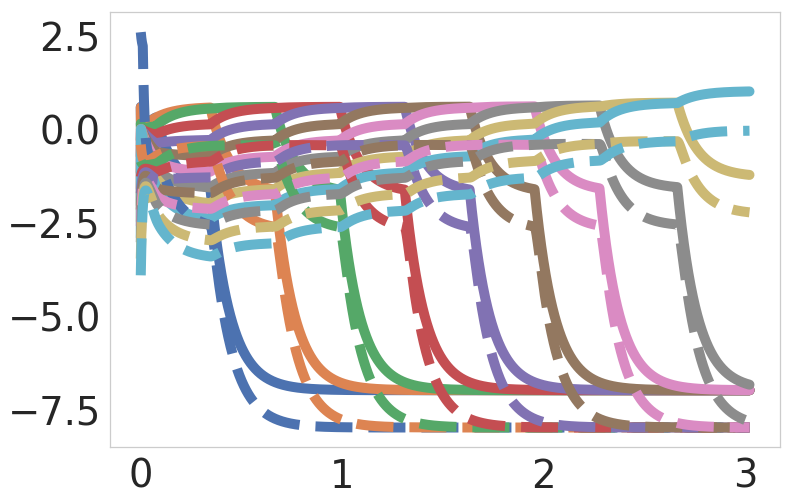

In [10]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

for index, current in enumerate(I.T):
    ax1.plot(manager.time, current, lw=lw, color=colors[index])
for index, s in enumerate(S.T):
    ax1.plot(manager.time, s, ls='--', lw=lw, color=colors[index])

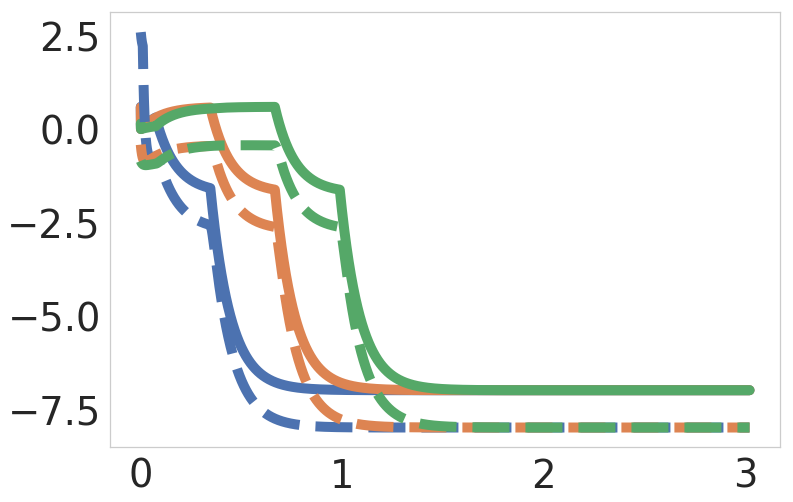

In [11]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

for index, current in enumerate(I.T):
    if index < 3:
        ax1.plot(manager.time, current, lw=lw, color=colors[index])
for index, s in enumerate(S.T):
    if index < 3:
        ax1.plot(manager.time, s, ls='--', lw=lw, color=colors[index])

## Disambiguation

[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [ 4]
 [ 5]
 [ 6]
 [17]
 [18]
 [19]]
CPU times: user 168 ms, sys: 40 ms, total: 208 ms
Wall time: 123 ms


../connectivity_functions.py:15: RuntimeWarning: invalid value encountered in true_divide
  x = P / outer


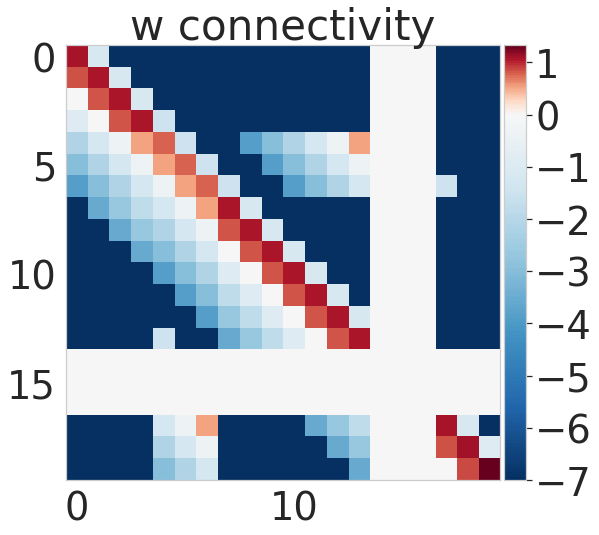

In [12]:
%%time 
sigma_out = 0.05
tau_z_pre = 0.050
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 20
n_patterns = minicolumns

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.000
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 0.0
epochs = 1
T_persistence = 0.025

# Manager properties
values_to_save = ['o', 'i', 'z_pre', 's']

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)

# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)


sigma_number = 15
samples = 25
sigma_max = 2

# Build the representation
representation_overlap = 1.0
sequence_overlap = 0.3
patterns_per_sequence = 10
activity_representation = create_overalaped_representation(manager, representation_overlap, sequence_overlap)
representation = PatternsRepresentation(activity_representation, minicolumns=minicolumns)
inter_pulse_intervals[patterns_per_sequence - 1] = inter_sequence_interval

print(activity_representation)

    
# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)
# Set the persistent time
manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence)
plot_weight_matrix(manager)

1.0
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 4, 5, 6]
[0.038, 0.035, 0.031, 0.042, 0.049, 0.044, 0.057, 0.042, 0.039, 0.045, 0.054, 0.045, 0.044, 0.047, 0.041, 0.052000000000000005, 0.051000000000000004]


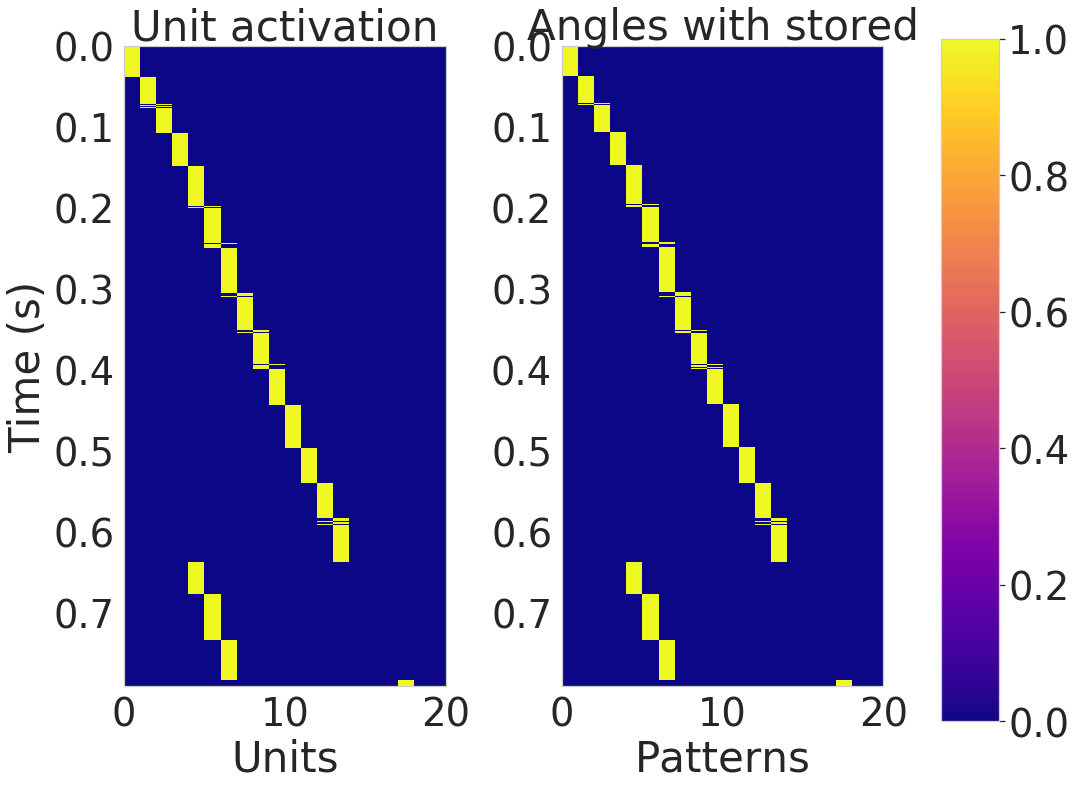

In [13]:
T_cue = 2 * manager.nn.tau_s
T_recall = 3 * T_persistence * patterns_per_sequence + T_cue

nr1 = representation.network_representation[:patterns_per_sequence]
nr2 = representation.network_representation[patterns_per_sequence:]

# Success 1
aux1 = calculate_recall_quantities(manager, nr1, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
success1, pattern_sequence1, persistent_times1, timings1 = aux1
print(success1)
print(pattern_sequence1)
print(persistent_times1)

plot_network_activity_angle(manager, time_y=True);

1.0
[10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19]
[0.041, 0.036000000000000004, 0.041, 0.049, 0.039, 0.047, 0.059000000000000004, 0.046, 0.049, 0.20700000000000002, 0.011, 0.107, 0.054]


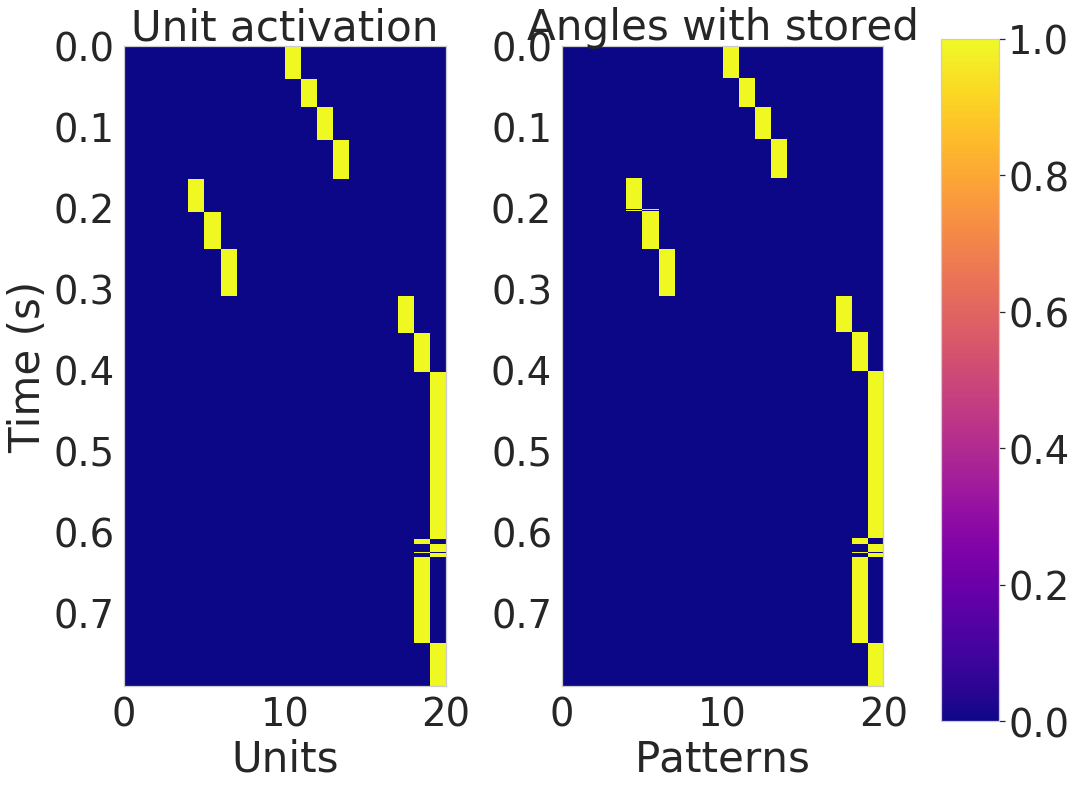

In [14]:
# Success 2
aux2 = calculate_recall_quantities(manager, nr2, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
success2, pattern_sequence2, persistent_times2, timings2 = aux2
print(success2)
print(pattern_sequence2)
print(persistent_times2)

plot_network_activity_angle(manager, time_y=True);